In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

## Load data

In [3]:
adata_joanito = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.preprocessed.NanoMnT.ManualAnnot.h5ad')

In [4]:
dict_Identifier_to_lvl_1_CellType = dict()
dict_Identifier_to_lvl_2_CellType = dict()

In [10]:
adata_joanito_TME = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/TME_annot_temp_files/Joanito.preprocessed.NanoMnT.nonTumor.preAnnot.h5ad')

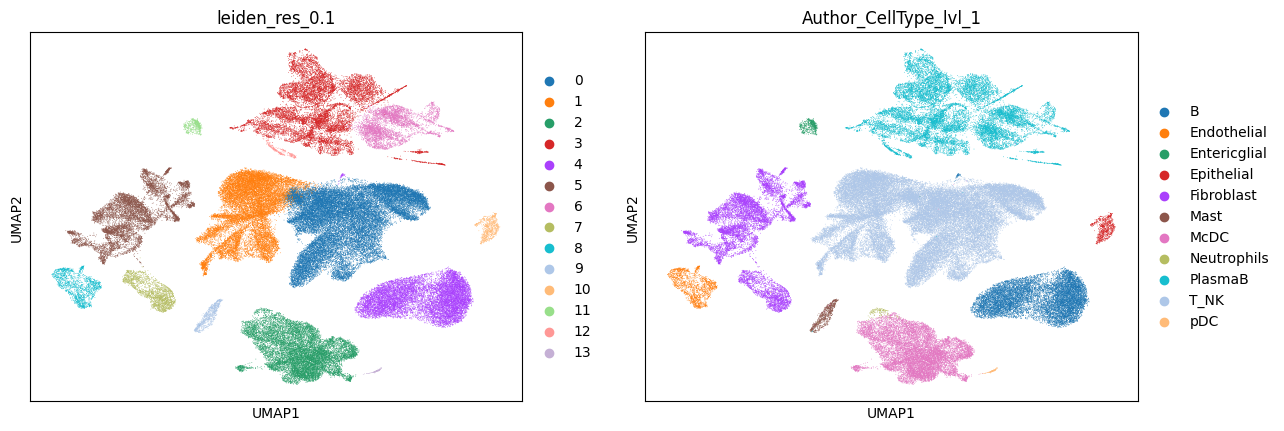

In [11]:
sc.pl.umap(adata_joanito_TME, color=['leiden_res_0.1', 'Author_CellType_lvl_1'])

In [20]:
Myeloid_markers = { 'Monocytes' : ['S100A6', 'S100A8', 'CD14', 'CCR2', 'FCGR3A', 'CX3CR1'], 
                   'Macrophage' : ['C1QA', 'C1QB', 'C1QC'],
                   'Mast' :         ['MS4A2', 'TPSAB1', 'TPSB2', 'CPA3' ], 
                   'DC' : ['CD1C', 'CLEC9A', 'CLEC10A', 'LAMP3'],
                   'pDC' : ['CLEC4C', 'GZMB', "IL3RA", ],
                   'Neutrophils' : ['FPR1', 'CSF3R', 'FCGR3B', 'NAMPT', 'MNDA', 'FUT4', 'G0S2'],
                   }

## Myeloid cells - leiden_res_0.1: 2, 9, 13

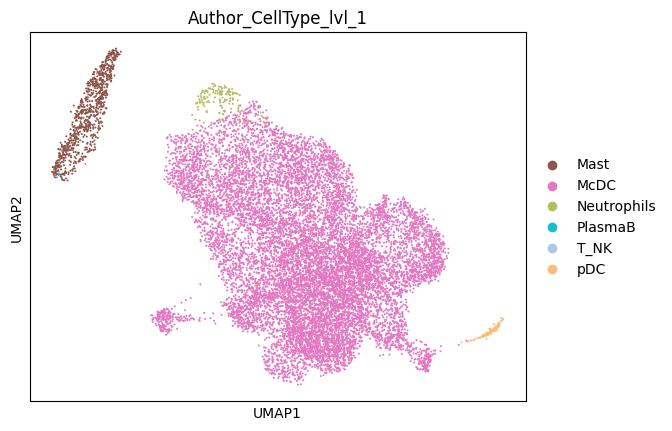

In [14]:
adata_joanito_mye = adata_joanito_TME[adata_joanito_TME.obs['leiden_res_0.1'].isin(['2', '9', '13'])].copy()
sc.pl.umap(adata_joanito_mye, color=['Author_CellType_lvl_1'])
adata_joanito_mye = adata_joanito_mye.raw.to_adata()

In [16]:
temp = list()
for SampleID, edf in adata_joanito_mye.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'N/A'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_joanito_mye = adata_joanito_mye[~(adata_joanito_mye.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_joanito_mye)
sc.pp.log1p(adata_joanito_mye)
sc.pp.highly_variable_genes(adata_joanito_mye, n_top_genes=2000, batch_key="SampleID")

adata_joanito_mye.raw = adata_joanito_mye.copy()
adata_joanito_mye = adata_joanito_mye[:, adata_joanito_mye.var.highly_variable]

sc.pp.scale(adata_joanito_mye, max_value=10)
sc.tl.pca(adata_joanito_mye, svd_solver="arpack")

sc.pp.neighbors(adata_joanito_mye, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_joanito_mye, random_state=42)

/tmp/ipykernel_135035/3486003549.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_joanito_mye.obs.groupby('SampleID'):


/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


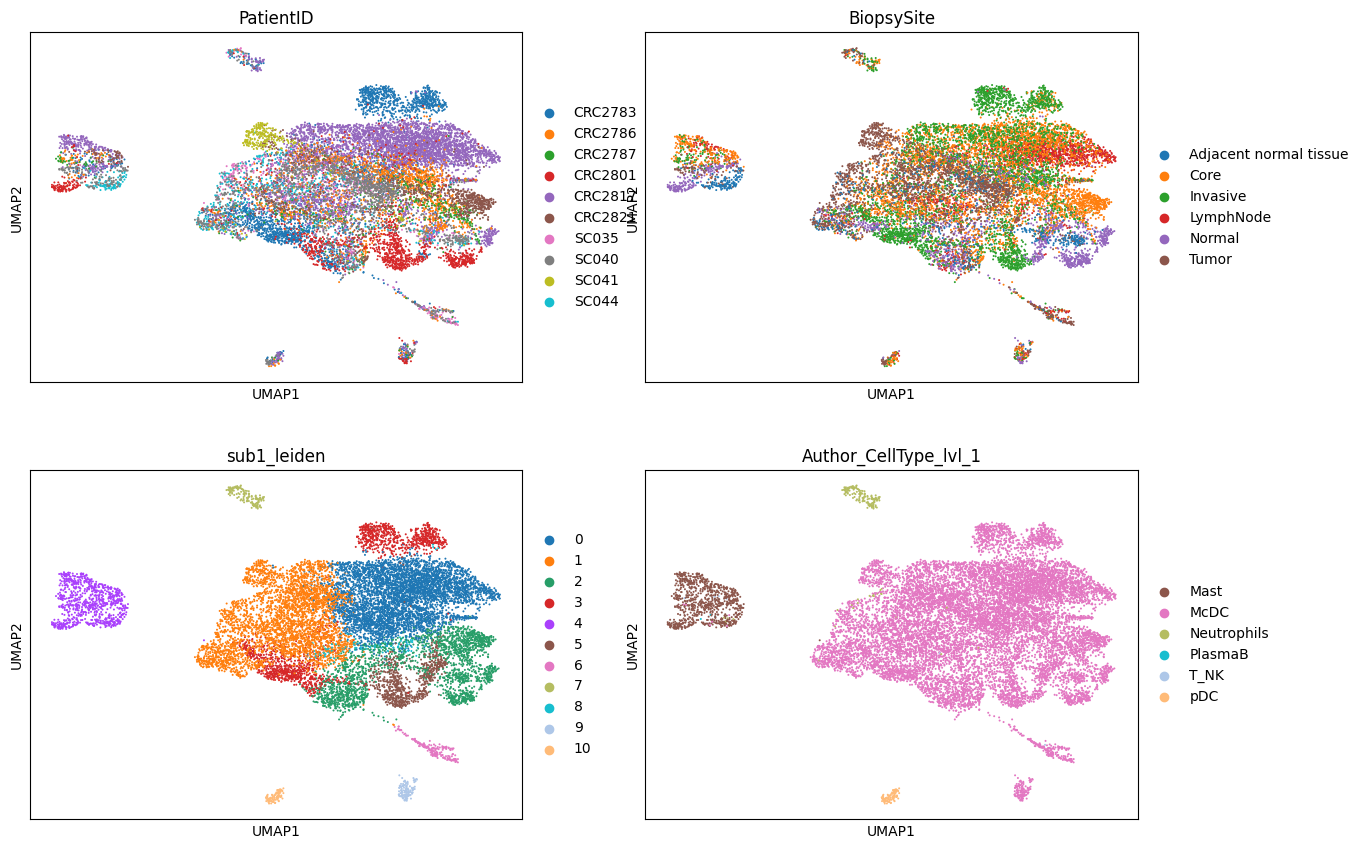

In [18]:
sc.tl.leiden(adata_joanito_mye, resolution=0.2, key_added='sub1_leiden')
sc.pl.umap(adata_joanito_mye, color=['PatientID', 'BiopsySite', 'sub1_leiden', 'Author_CellType_lvl_1'], ncols=2)

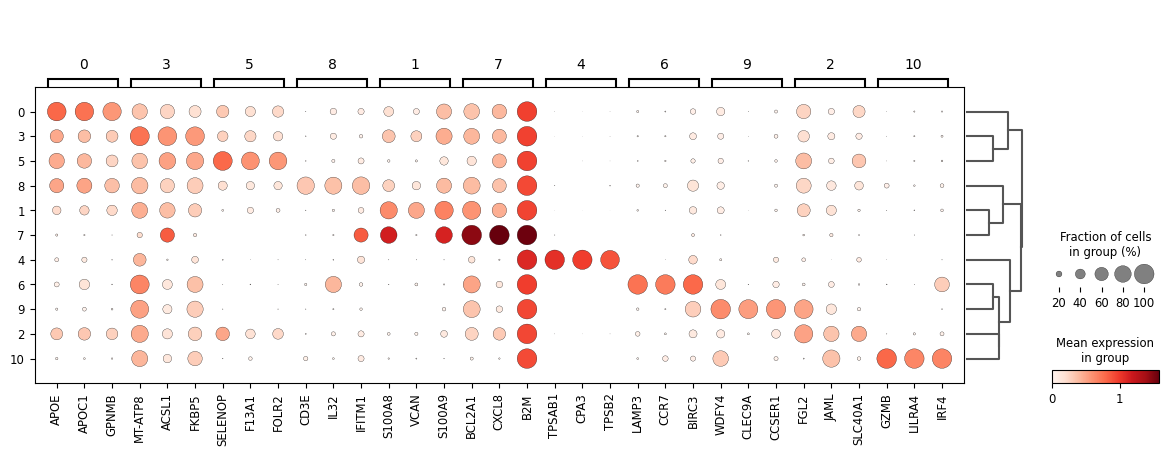

In [19]:
sc.tl.rank_genes_groups(adata_joanito_mye, groupby='sub1_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_joanito_mye, n_genes=3, groupby='sub1_leiden')

<Axes: xlabel='count', ylabel='sub1_leiden'>

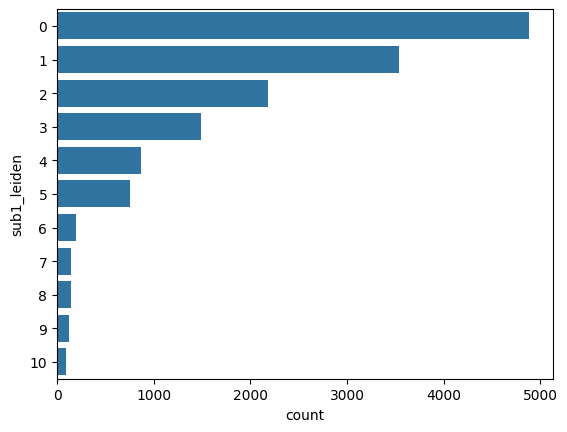

In [24]:
sns.countplot(data=adata_joanito_mye.obs, y='sub1_leiden')

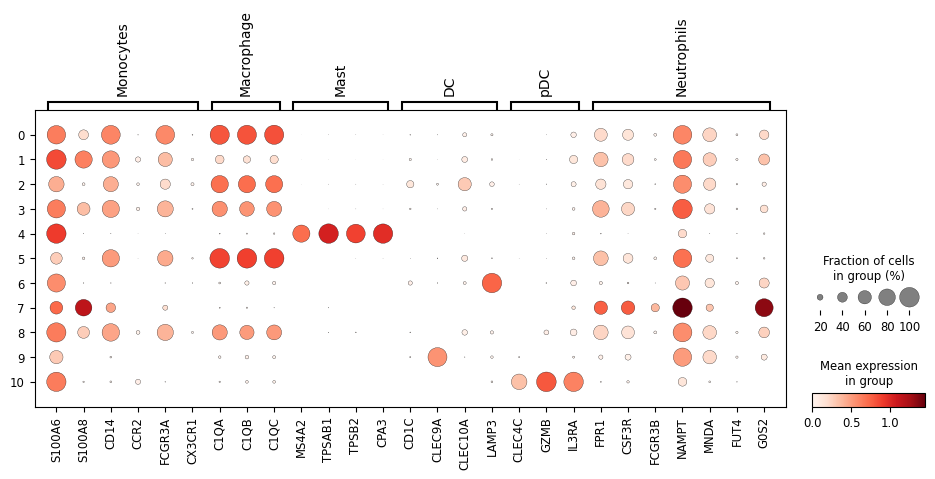

In [21]:
sc.pl.dotplot(adata_joanito_mye, var_names=Myeloid_markers, groupby='sub1_leiden')

### leiden 4 → Mast

In [31]:
for tup in adata_joanito_mye[adata_joanito_mye.obs['sub1_leiden'].isin(['4'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Mast'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Mast'

### leiden 10 → pDC

In [23]:
for tup in adata_joanito_mye[adata_joanito_mye.obs['sub1_leiden'].isin(['10'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Dendritic'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'pDC'

### leiden 0, 2, 3, 5, 8 → Macrophage

In [25]:
for tup in adata_joanito_mye[adata_joanito_mye.obs['sub1_leiden'].isin(['0', '2', '3', '5', '8'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Monocyte/Macrophage'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Macrophage'

### leiden 1, 4, 7 → Monocyte

In [26]:
for tup in adata_joanito_mye[adata_joanito_mye.obs['sub1_leiden'].isin(['1', '4', '7',])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Monocyte/Macrophage'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Monocyte'

### leiden 6, 9 → cDC

In [27]:
for tup in adata_joanito_mye[adata_joanito_mye.obs['sub1_leiden'].isin(['6', '9',])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Dendritic'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'cDC'

In [32]:
adata_joanito_mye.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_joanito_mye.obs['Identifier'] ]
adata_joanito_mye.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_joanito_mye.obs['Identifier'] ]

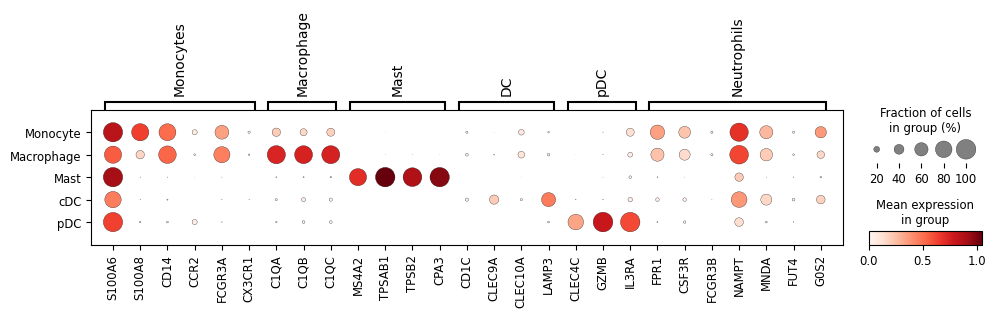

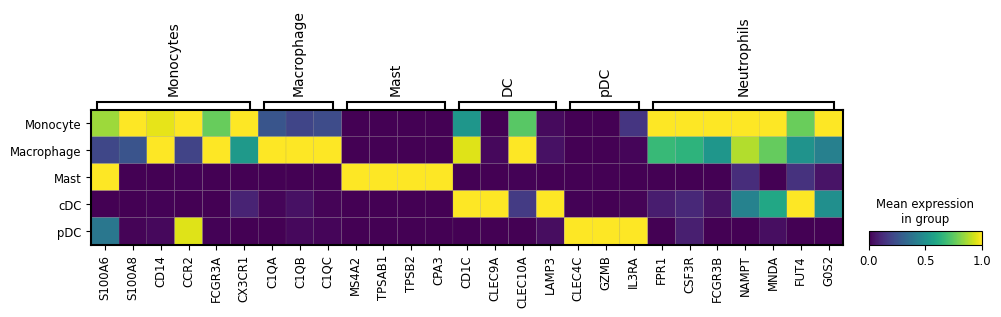

In [34]:
sc.pl.dotplot(adata_joanito_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])
sc.pl.matrixplot(adata_joanito_mye, var_names=Myeloid_markers, groupby='Manual_CellType_lvl_2', standard_scale='var', categories_order=['Monocyte', 'Macrophage', 'Mast', 'cDC', 'pDC'])

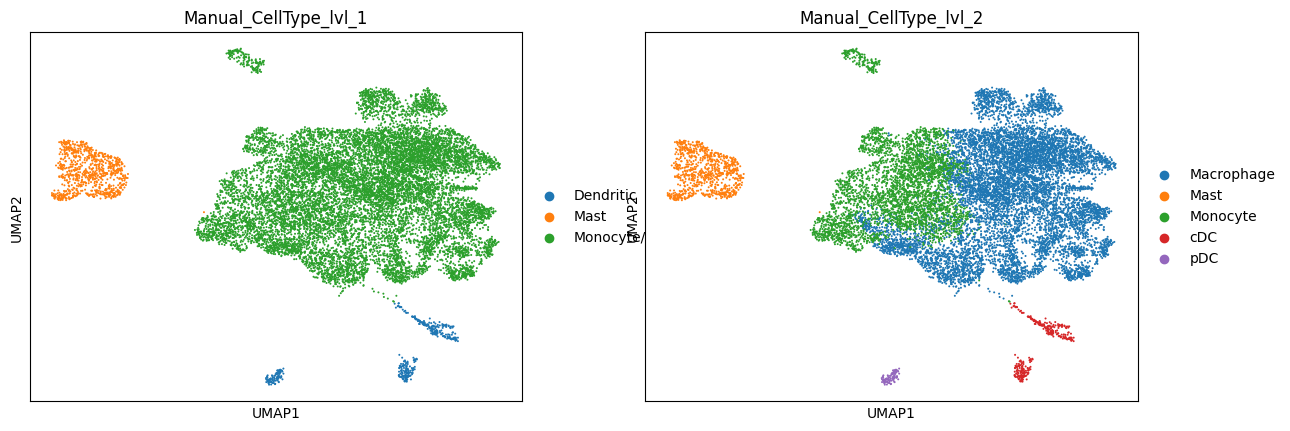

In [33]:
sc.pl.umap(adata_joanito_mye, color=['Manual_CellType_lvl_1', 'Manual_CellType_lvl_2'])

## Epithelial cells - leiden_res_0.1: 10

In [35]:
smillie_marker_converted = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/entrez_id_conversion/colon_epithelial_marker.ensembl_id.csv')
dict_InitialAlias_to_GeneName = { tup.initial_alias : tup.name for tup in smillie_marker_converted.itertuples() }

smillie_marker = pd.read_csv('/node200data/18parkky/datasets/reference/marker_genes/colon/Smillie_et_al/colon_epithelial_marker.csv')
for gene in smillie_marker['gene']:
    try: dict_InitialAlias_to_GeneName[gene]
    except KeyError: dict_InitialAlias_to_GeneName[gene] = None
smillie_marker['gene'] = [ dict_InitialAlias_to_GeneName[gene] for gene in smillie_marker['gene'] ]
print(smillie_marker.shape[0])
smillie_marker.dropna(inplace=True)
print(smillie_marker.shape[0])
IntestinalEpiCellTypes = [ ident for ident in set(smillie_marker['ident']) if ident[:2] != 'E.' ]

3045
2666


In [118]:
adata_joanito_epi = adata_joanito_TME[adata_joanito_TME.obs['leiden_res_0.1'].isin(['10'])].copy()
adata_joanito_epi = adata_joanito_epi.raw.to_adata()

temp = list()
for SampleID, edf in adata_joanito_epi.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'N/A'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'
        
adata_joanito_epi = adata_joanito_epi[~(adata_joanito_epi.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_joanito_epi)
sc.pp.log1p(adata_joanito_epi)
sc.pp.highly_variable_genes(adata_joanito_epi, n_top_genes=1000, batch_key="SampleID")

adata_joanito_epi.raw = adata_joanito_epi.copy()
# adata_joanito_epi = adata_joanito_epi[:, adata_joanito_epi.var.highly_variable]
adata_joanito_epi = adata_joanito_epi[:, adata_joanito_epi.var.index.isin(smillie_marker['gene'])]

sc.pp.scale(adata_joanito_epi, max_value=10)
sc.tl.pca(adata_joanito_epi, svd_solver="arpack")

sc.pp.neighbors(adata_joanito_epi, n_neighbors=50, n_pcs=40)
# sc.external.pp.bbknn(adata_joanito_epi, batch_key='SampleID', )
sc.tl.umap(adata_joanito_epi, random_state=42)

/tmp/ipykernel_135035/3264323496.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_joanito_epi.obs.groupby('SampleID'):
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [120]:
sc.tl.leiden(adata_joanito_epi, resolution=0.5, key_added='sub1_leiden')

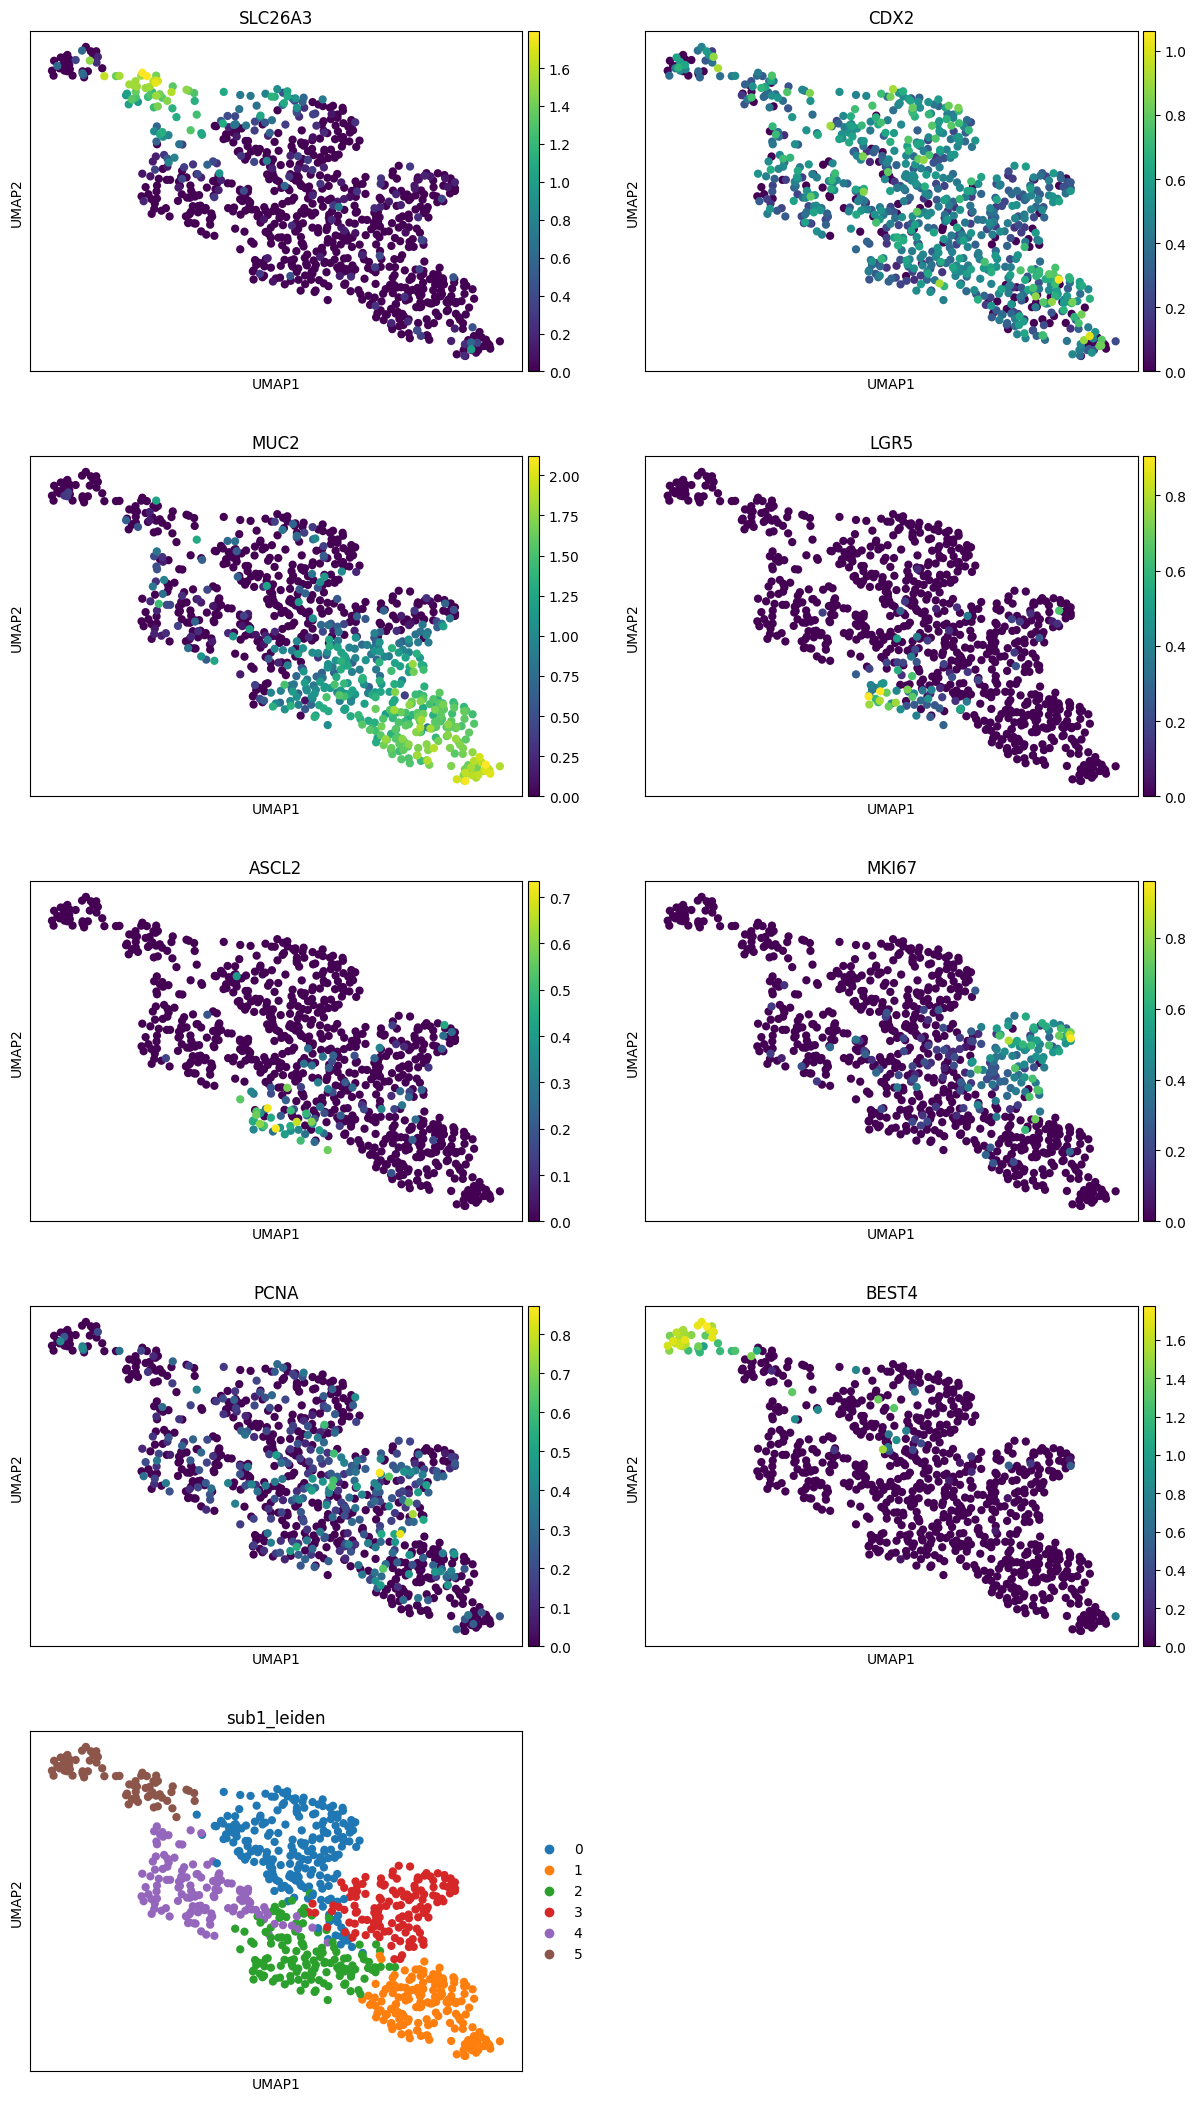

In [132]:
sc.pl.umap(adata_joanito_epi, color=['SLC26A3', 'CDX2', 'MUC2', 'LGR5', 'ASCL2', 'MKI67', 'PCNA', 'BEST4', 'sub1_leiden'], ncols=2)

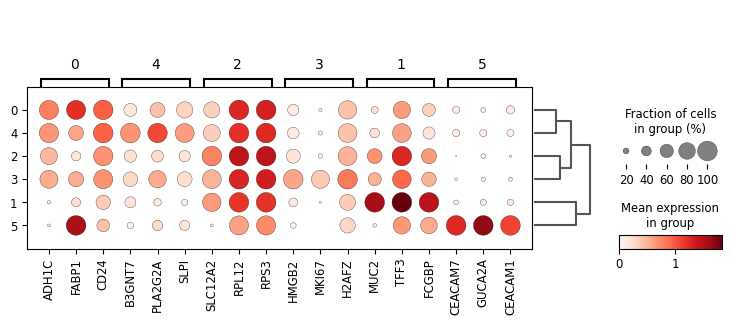

In [133]:
sc.tl.rank_genes_groups(adata_joanito_epi, groupby='sub1_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_joanito_epi, n_genes=3, groupby='sub1_leiden')

In [134]:
varIndex = adata_joanito_epi.raw.to_adata().var.index 

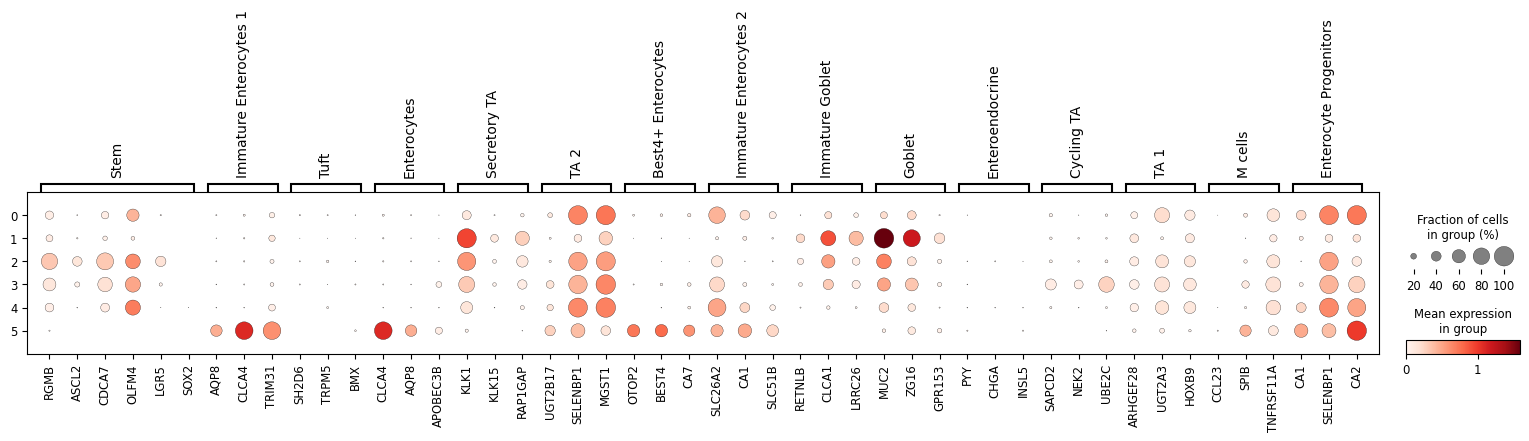

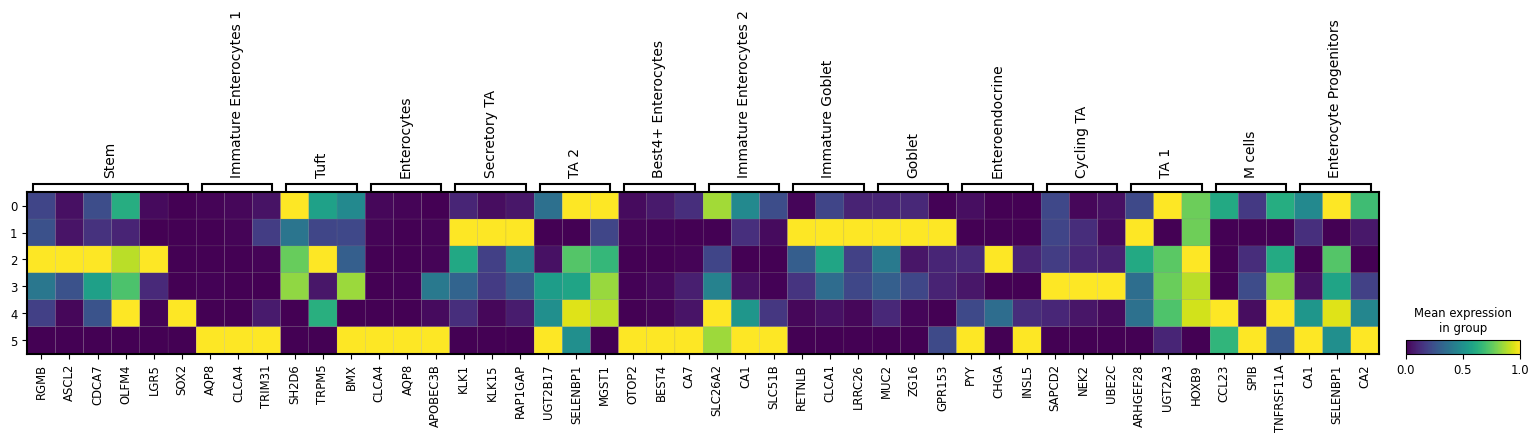

In [135]:
dict_ident_to_marker = dict()
n_genes = 3

for ident in IntestinalEpiCellTypes:
    top_n_genes = list() 
    for gene in smillie_marker[(smillie_marker['ident']==ident) & 
                               (smillie_marker['pvalD']<=0.01) & 
                               (smillie_marker['pvalC']<=0.01)].sort_values('log2fc', ascending=False)['gene']:
        if gene in varIndex:
            top_n_genes.append(gene)
            if len(top_n_genes) == n_genes: break
    
    dict_ident_to_marker[ident] = top_n_genes
    
dict_ident_to_marker['Stem'].append( 'OLFM4' )
dict_ident_to_marker['Stem'].append( 'LGR5' )
dict_ident_to_marker['Stem'].append( 'SOX2' )

sc.pl.dotplot( adata_joanito_epi, var_names=dict_ident_to_marker, groupby='sub1_leiden', swap_axes=False, )
sc.pl.matrixplot( adata_joanito_epi, var_names=dict_ident_to_marker, groupby='sub1_leiden', swap_axes=False, standard_scale='var')

In [136]:
for ident, markers in dict_ident_to_marker.items():
    sc.tl.score_genes(adata_joanito_epi, markers, score_name=f'{ident}_score')

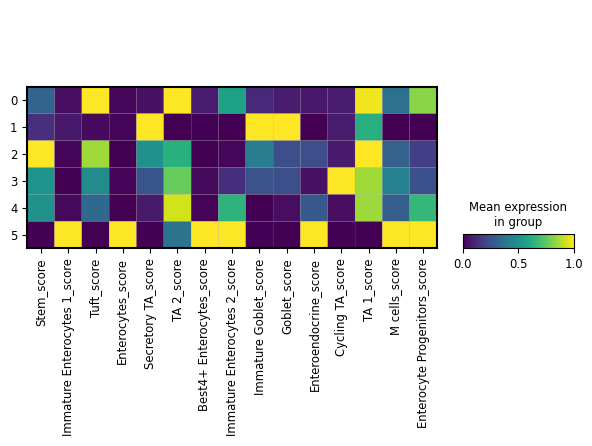

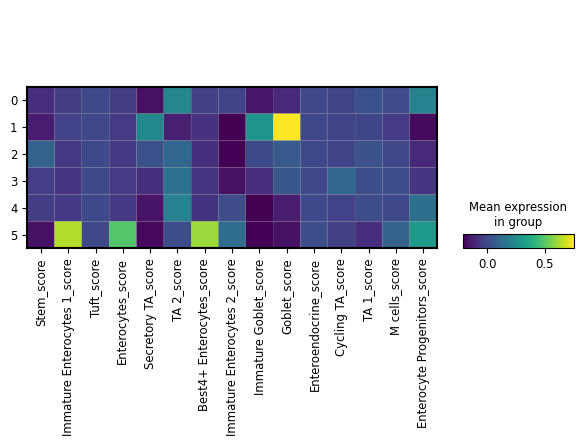

In [138]:
sc.pl.matrixplot(adata_joanito_epi, var_names=[ f'{k}_score' for k in list(dict_ident_to_marker.keys()) ], groupby='sub1_leiden', standard_scale='var')
sc.pl.matrixplot(adata_joanito_epi, var_names=[ f'{k}_score' for k in list(dict_ident_to_marker.keys()) ], groupby='sub1_leiden')

### leiden 0, 4 → Enterocyte progenitors? TA?

In [194]:
adata_joanito_epi_l0 = adata_joanito_epi[adata_joanito_epi.obs['sub1_leiden'].isin( ['0', '4'] )].copy()
adata_joanito_epi_l0 = adata_joanito_epi_l0.raw.to_adata()

In [195]:
temp = list()
for SampleID, edf in adata_joanito_epi_l0.obs.groupby('SampleID'):
    if len(edf) <= 1:
        print(SampleID, len(edf))
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_joanito_epi_l0 = adata_joanito_epi_l0[~(adata_joanito_epi_l0.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_joanito_epi_l0)
sc.pp.log1p(adata_joanito_epi_l0)
sc.pp.highly_variable_genes(adata_joanito_epi_l0, n_top_genes=2000, batch_key="SampleID")

adata_joanito_epi_l0.raw = adata_joanito_epi_l0.copy()
# adata_joanito_epi_l0 = adata_joanito_epi_l0[:, adata_joanito_epi_l0.var.highly_variable]
adata_joanito_epi_l0 =  adata_joanito_epi_l0[:, adata_joanito_epi_l0.var.index.isin(smillie_marker[(smillie_marker['ident'].isin([ 'Cycling TA', 
                                                                                                                                  'TA 1', 'TA 2', 
                                                                                                                                  'Immature Enterocytes 2', 
                                                                                                                                  'Stem', 'Enterocyte Progenitors']))]['gene'])]

sc.pp.scale(adata_joanito_epi_l0, max_value=10)
sc.tl.pca(adata_joanito_epi_l0, svd_solver="arpack")

sc.pp.neighbors(adata_joanito_epi_l0, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_joanito_epi_l0, random_state=42)

EXT093 1


/tmp/ipykernel_135035/675166840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_joanito_epi_l0.obs.groupby('SampleID'):
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [207]:
for ident, markers in dict_ident_to_marker.items():
    sc.tl.score_genes(adata_joanito_epi_l0, markers, score_name=f'{ident}_score')

In [204]:
sc.tl.leiden(adata_joanito_epi_l0, resolution=0.2, key_added='sub2_leiden')

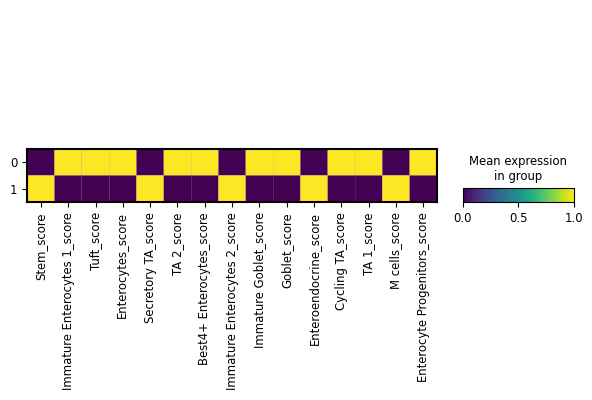

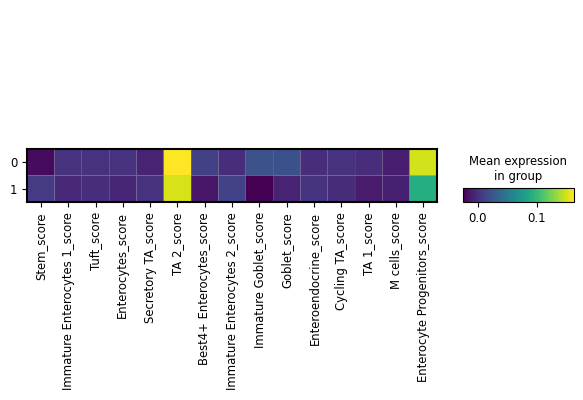

In [210]:
sc.pl.matrixplot(adata_joanito_epi_l0, var_names=[ f'{k}_score' for k in list(dict_ident_to_marker.keys()) ], groupby='sub2_leiden', standard_scale='var')
sc.pl.matrixplot(adata_joanito_epi_l0, var_names=[ f'{k}_score' for k in list(dict_ident_to_marker.keys()) ], groupby='sub2_leiden')

In [211]:
for tup in adata_joanito_epi_l0[adata_joanito_epi_l0.obs['sub2_leiden'].isin(['0', '1'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'TA 1'

### leiden 1, 2, 3 → Goblet lineage

In [146]:
adata_joanito_epi_goblet = adata_joanito_epi[adata_joanito_epi.obs['sub1_leiden'].isin( ['1', '2', '3'] )].copy()
adata_joanito_epi_goblet = adata_joanito_epi_goblet.raw.to_adata()

In [147]:
temp = list()
for SampleID, edf in adata_joanito_epi_goblet.obs.groupby('SampleID'):
    if len(edf) <= 1:
        print(SampleID, len(edf))
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Epithelial'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_joanito_epi_goblet = adata_joanito_epi_goblet[~(adata_joanito_epi_goblet.obs['SampleID'].isin(temp))].copy()

sc.pp.normalize_total(adata_joanito_epi_goblet)
sc.pp.log1p(adata_joanito_epi_goblet)
sc.pp.highly_variable_genes(adata_joanito_epi_goblet, n_top_genes=2000, batch_key="SampleID")

adata_joanito_epi_goblet.raw = adata_joanito_epi_goblet.copy()
# adata_joanito_epi_goblet = adata_joanito_epi_goblet[:, adata_joanito_epi_goblet.var.highly_variable]
adata_joanito_epi_goblet =  adata_joanito_epi_goblet[:, adata_joanito_epi_goblet.var.index.isin(smillie_marker[(smillie_marker['ident'].isin(['Goblet', 'Immature Goblet', 'TA 1', 'TA 2', 'Secretory TA', 'Stem']))]['gene'])]

sc.pp.scale(adata_joanito_epi_goblet, max_value=10)
sc.tl.pca(adata_joanito_epi_goblet, svd_solver="arpack")

sc.pp.neighbors(adata_joanito_epi_goblet, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_joanito_epi_goblet, random_state=42)

/tmp/ipykernel_135035/194735748.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_joanito_epi_goblet.obs.groupby('SampleID'):
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [163]:
sc.tl.leiden(adata_joanito_epi_goblet, resolution=0.5, key_added='sub2_leiden')

In [157]:
for ident, markers in dict_ident_to_marker.items():
    sc.tl.score_genes(adata_joanito_epi_goblet, markers, score_name=f'{ident}_score')

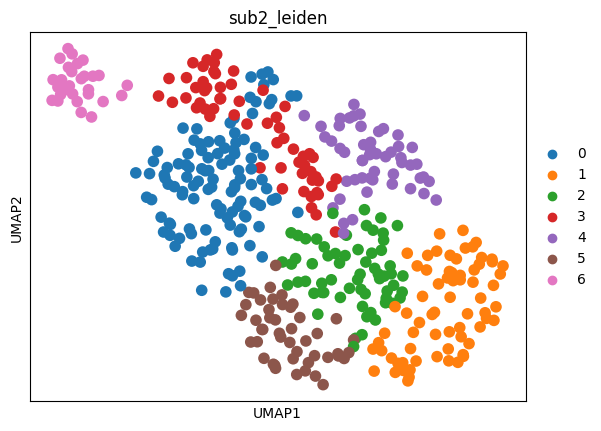

In [167]:
sc.pl.umap(adata_joanito_epi_goblet, color=['sub2_leiden'])

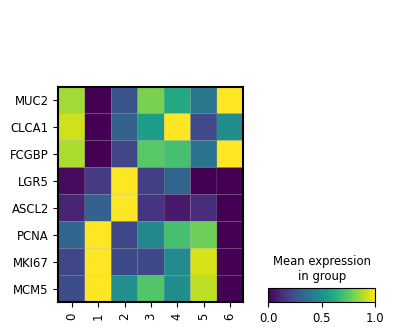

In [184]:
sc.pl.matrixplot(adata_joanito_epi_goblet, var_names=['MUC2', 'CLCA1', 'FCGBP', 'LGR5', 'ASCL2', 'PCNA', 'MKI67', 'MCM5'], groupby='sub2_leiden', swap_axes=True, standard_scale='var')

In [209]:
for tup in adata_joanito_epi_goblet[adata_joanito_epi_goblet.obs['sub2_leiden'].isin(['0', '3', '4', '5', '6'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Goblet'
    
for tup in adata_joanito_epi_goblet[adata_joanito_epi_goblet.obs['sub2_leiden'].isin(['1'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'TA 2'
    
for tup in adata_joanito_epi_goblet[adata_joanito_epi_goblet.obs['sub2_leiden'].isin(['2'])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Stem'

In [187]:
adata_joanito_epi_goblet.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_joanito_epi_goblet.obs['Identifier'] ]
adata_joanito_epi_goblet.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_joanito_epi_goblet.obs['Identifier'] ]

### leiden 5 → Mixture of BEST4+/- enterocytes

In [217]:
set(smillie_marker['ident'])

{'Best4+ Enterocytes',
 'Cycling TA',
 'E.Absorptive',
 'E.Absorptive_All',
 'E.Epithelial',
 'E.Immature_Enterocytes',
 'E.Secretory',
 'E.Secretory_All',
 'Enterocyte Progenitors',
 'Enterocytes',
 'Enteroendocrine',
 'Goblet',
 'Immature Enterocytes 1',
 'Immature Enterocytes 2',
 'Immature Goblet',
 'M cells',
 'Secretory TA',
 'Stem',
 'TA 1',
 'TA 2',
 'Tuft'}

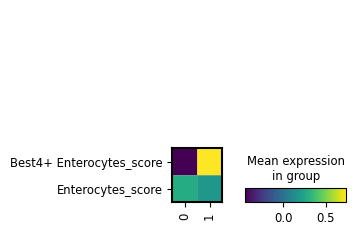

In [219]:
adata_joanito_epi_l5 = adata_joanito_epi[adata_joanito_epi.obs['sub1_leiden'].isin( ['5'] )].copy()
# adata_joanito_epi_l5 = adata_joanito_epi_l5.raw.to_adata()
sc.tl.leiden(adata_joanito_epi_l5, resolution=0.2, key_added='sub2_leiden')

for ident, markers in dict_ident_to_marker.items():
    sc.tl.score_genes(adata_joanito_epi_l5, markers, score_name=f'{ident}_score')
    
sc.pl.matrixplot(adata_joanito_epi_l5, var_names=['Best4+ Enterocytes_score', 'Enterocytes_score',], groupby='sub2_leiden', swap_axes=True,)

In [226]:
for tup in adata_joanito_epi_l5[adata_joanito_epi_l5.obs['sub2_leiden'].isin(['1', ])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'BEST4+ Enterocytes'
    
for tup in adata_joanito_epi_l5[adata_joanito_epi_l5.obs['sub2_leiden'].isin(['0', ])].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Epithelial'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'Enterocytes'

### Overview results

In [227]:
adata_joanito_epi.obs['Manual_CellType_lvl_1'] = [ dict_Identifier_to_lvl_1_CellType[Identifier] for Identifier in adata_joanito_epi.obs['Identifier'] ]
adata_joanito_epi.obs['Manual_CellType_lvl_2'] = [ dict_Identifier_to_lvl_2_CellType[Identifier] for Identifier in adata_joanito_epi.obs['Identifier'] ]

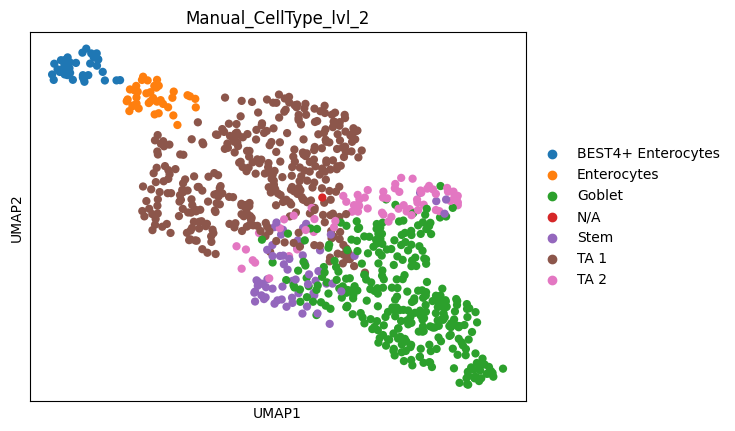

In [229]:
sc.pl.umap(adata_joanito_epi, color=['Manual_CellType_lvl_2'])

In [230]:
saveWithPickle(dict_Identifier_to_lvl_1_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Mye_and_Epi.lvl1')
saveWithPickle(dict_Identifier_to_lvl_2_CellType, '/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/dict_Identifier_to_CellType', 'Mye_and_Epi.lvl2')